# Getting the run back on track

## HDF5 Error

This error occured when starting from an earlier restart file. Apparently it is caused when ICON tries to write into existing (potentiall faulty) output files. I solved this by removing the existing output. removing here means removing from the directory, i.e. moving. I was to timid to straight away delete it.

`/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/15005740-les+4k.log`

```
 8384 3835: ERROR, reshGetElem, resource_handle.c, line 410, called from subtypeInqActiveIndex
 8385 3835: errorString: "Error while trying to resolve the ID "subtypeID" in `subtypeInqActiveIndex()`: the value is garbage (= 132849088, which resol
 8386 3835:   This is either the result of using an uninitialized variable,
 8387 3835:   of using a value as an ID that is not an ID,
 8388 3835:   or of using an ID after it has been invalidated."
 8389 3835: HDF5-DIAG: Error detected in HDF5 (1.12.1) MPI-process 3835:
 8390 3835:   #000: /home/k/k202066/.spack/stage/spack-stage-hdf5-1.12.1-tvymb53dysodq7atyt6kpvx4foh6wwog/spack-src/src/H5A.c line 1666 in H5Aexists():
 8391 3835:     major: Invalid arguments to routine
 8392 3835:     minor: Inappropriate type
 8393 3835:   #001: /home/k/k202066/.spack/stage/spack-stage-hdf5-1.12.1-tvymb53dysodq7atyt6kpvx4foh6wwog/spack-src/src/H5VLint.c line 1741 in H5VL_vol
 8394 3835:     major: Invalid arguments to routine
 8395 3835:     minor: Inappropriate type
 8396 3835: HDF5-DIAG: Error detected in HDF5 (1.12.1) MPI-process 3835:
 8397 3835:   #000: /home/k/k202066/.spack/stage/spack-stage-hdf5-1.12.1-tvymb53dysodq7atyt6kpvx4foh6wwog/spack-src/src/H5Adeprec.c line 137 in H5Acrea
 8398 3835:     major: Invalid arguments to routine
 8399 3835:     minor: Inappropriate type
 8400 3835:   #001: /home/k/k202066/.spack/stage/spack-stage-hdf5-1.12.1-tvymb53dysodq7atyt6kpvx4foh6wwog/spack-src/src/H5VLint.c line 1741 in H5VL_vol
 8401 3835:     major: Invalid arguments to routine
 8402 3835:     minor: Inappropriate type
 8403 3835: Error (cdf_close) : NetCDF: Can't add HDF5 file metadata                                                                                   
 8404 3835:
 8405 3835: [l30271:2244111:0:2244111] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x18)
```


In [1]:
import os
import pandas as pd
import re

NONE_TIMESTAMP = pd.Timestamp('1789-07-14 13:12:00')

def extract_datetime(filename):
    """
    Extracts the date from a timestamp in a filename and returns it as a pandas datetime object.

    The filename is expected to contain a timestamp in the format 'YYYYMMDDTHHMMSSZ'.
    This function extracts only the date part ('YYYYMMDD') and converts it to a pandas Timestamp.
    If no such timestamp is found, the function returns None.

    Parameters:
        filename (str): The filename containing the timestamp.
    Returns:
        pd.Timestamp or None: The extracted date as a pandas Timestamp object, or None if no timestamp is found.
    """
    global NONE_TIMESTAMP
    match = re.search(r'\d{8}T\d{6}Z', filename)
    if match:
        datetime_str = match.group(0)[:15]
        return pd.to_datetime(datetime_str, format='%Y%m%dT%H%M%S')
    return NONE_TIMESTAMP

def datetime2str(datetime_obj):
    """
    Converts a pandas datetime object into a string formatted as 'YYYYMMDDTHHMMSSZ'.

    Parameters:
        datetime_obj (pd.Timestamp): The pandas datetime object to be converted.
    Returns:
        str: The formatted string representing the datetime.
    """
    if isinstance(datetime_obj, pd.Timestamp):
        return datetime_obj.strftime('%Y%m%dT%H%M%SZ')
    else:
        raise ValueError("Input must be a pandas Timestamp object.")

def has_timestamp(file_path):
    """
    Checks if a given file path contains a timestamp in the format 'YYYYMMDDTHHMMSSZ'.

    Parameters:
        file_path (str): The file path to check for a timestamp.
    Returns:
        bool: True if a timestamp is found, False otherwise.
    """
    match = re.search(r'\d{8}T\d{6}Z', file_path)
    return match is not None

In [38]:
import os
import shutil

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
link = os.path.join(path, 'multifile_restart_atm.mfr')
restart_date = extract_datetime(os.readlink(link))
print('restart date:', restart_date)

files = [f for f in os.listdir(path) if has_timestamp(f)]         # everything with a timestamp
files = [f for f in files if not f == os.readlink(link)]          # but not the currently used restart file
files = [f for f in files if extract_datetime(f) >= restart_date] # files for after the restart
files = [os.path.join(path, f) for f in files]                    # convert to full paths
files = sorted(files, key=extract_datetime)                       # sort

destination = os.path.join(path, pd.Timestamp.now().strftime('%Y%m%dT%HZ'))


if len(files): 
    os.makedirs(destination, exist_ok=True)
    print(f'moving files to destination: `{os.path.basename(destination)}`')
    for file in files:
        print(file)
        shutil.move(file, destination)
else:
    print('no files to move.')

restart date: 2020-01-25 13:30:00
no files to move.


In [3]:
# change symlink to restart file:
relink='ln -sfn TARGET LINK_NAME'

## RTTOV Error

After fixing the output problem, the run crashes because RTTOV complains about too high water vapor (`/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/15061780-les+4k.log`):
```
146906795  445:  2025/01/30  22:30:23  fatal error in module rttov_check_profiles.F90:0399
146906796  445:      some invalid atmospheric water vapour (profile number =      270)
```
This has been a problem before (`/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/14930757-les+4k.log`) and is the reason we went back to a earlier restart in the first place.

But what are the criteria of RTTOV? The log file states

In [4]:
import os

def find_by_name(directory, keyword, case_sensitive=True):
    """
    Search for files whose names contain the keyword.
    
    Args:
        directory (str): The path to the directory to search in.
        keyword (str): The keyword to search for in filenames.
        case_sensitive (bool): Whether the search should be case-sensitive. Defaults to True.
    
    Returns:
        list: A list of file paths whose names contain the keyword.
    """
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if case_sensitive:
                if keyword in file:
                    matching_files.append(os.path.join(root, file))
            else:
                if keyword.lower() in file.lower():
                    matching_files.append(os.path.join(root, file))
    return matching_files

def find_by_content(directory, keyword, case_sensitive=True):
    """
    Search for files whose content contains the keyword.
    
    Args:
        directory (str): The path to the directory to search in.
        keyword (str): The keyword to search for in file contents.
        case_sensitive (bool): Whether the search should be case-sensitive. Defaults to True.
    
    Returns:
        list: A list of file paths whose content contains the keyword.
    """
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                    if case_sensitive:
                        if keyword in content:
                            matching_files.append(file_path)
                    else:
                        if keyword.lower() in content.lower():
                            matching_files.append(file_path)
            except UnicodeDecodeError: continue # Skip files that can't be decoded as text
            except PermissionError:    continue # Skip files that can't be opened due to permissions
    return matching_files
    
icon_base_path = '/work/mh0010/m300408/DVC-test/icon-aes'
path = os.path.join(icon_base_path, 'src')
os.listdir(path)

keyword = 'rttov'
# results = search_files(path, keyword, case_sensitive=False)

print(f"Files with '{keyword}' in name their name:")
for file in find_by_name(path, keyword, case_sensitive=False):
    print(file)
    
print(f"Files containing '{keyword}':")
for file in find_by_content(path, keyword, case_sensitive=False):
    print(file)

Files with 'rttov' in name their name:
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_rttov_test.f90
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_synsat_rttov_model_utils.o
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_synsat_rttov_model_utils.f90
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_rttov_test.o
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_rttov_forward_model.f90
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_rttov_forward_model.f90.d
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_rttov_test.f90.d
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_synsat_rttov_model_utils.f90.d
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_rttov_forward_model.o
/work/mh0010/m300408/DVC-test/icon-aes/src/synsat_rttov_forward_model/mo_rttov_instance.o
/work/mh00

In [5]:
keyword = 'rttov_check_profiles'
# results = search_files(path, keyword, case_sensitive=False)

print(f"Files containing '{keyword}':")
for file in find_by_content(icon_base_path, keyword, case_sensitive=False):
    print(file)

Files containing 'rttov_check_profiles':


In [6]:
import os

def find_lines_with_keyword(file_path, keyword, case_sensitive=True):
    """
    Retrieve all lines containing the keyword from a given file,
    along with their line numbers.
    
    Args:
        file_path (str): The path to the file to search in.
        keyword (str): The keyword to search for in the file's content.
        case_sensitive (bool): Whether the search should be case-sensitive. Defaults to True.
    
    Returns:
        dict: A dictionary where keys are line numbers (int) and values are the lines (str)
            that contain the keyword.
    """
    matching_lines = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_number, line in enumerate(f, start=1):
                if case_sensitive:
                    if keyword in line:
                        matching_lines[line_number] = line.rstrip('\n')  # Remove newline character
                else:
                    if keyword.lower() in line.lower():
                        matching_lines[line_number] = line.rstrip('\n')  # Remove newline character
    except UnicodeDecodeError: return {} # Skip files that can't be decoded as text
    except PermissionError:    return {} # Skip files that can't be opened due to permissions
    except FileNotFoundError:  return {} # Skip files that don't exist
    return matching_lines

In [33]:
icon_base_path = '/work/mh0010/m300408/DVC-test/icon-aes'
path = os.path.join(icon_base_path, 'src')
os.listdir(path)

keyword = 'f90'
keyword = 'rttov'
rttov_files = find_by_name(path, keyword, case_sensitive=False)
rttov_files = [f for f in rttov_files if f.endswith('.f90')]
print(f"Files with '{keyword}' in name their name: {len(rttov_files)}")

keyword = 'vapor'
keyword = 'limit'
# keyword = 'rttov_check_reg_limits'
print(f'searching for "{keyword}" in files:')
print()

for file in rttov_files:
    findings = find_lines_with_keyword(file, keyword)
    if not findings == dict():
        print(file)
        print(findings)
        print()

print('done')

Files with 'rttov' in name their name: 4
searching for "limit" in files:

/work/mh0010/m300408/DVC-test/icon-aes/src/atm_phy_nwp/mo_rttov_interface.f90
{30: '  USE mo_grid_config,         ONLY: l_limited_area', 722: '        ! limit qv to saturation and convert into volume mixing ratio (ppmv)', 903: '  IF (l_limited_area .AND. jg == 1) THEN', 950: '                l_pd_limit=.TRUE., l_extrapol=.FALSE.               )', 955: '                l_pd_limit=.TRUE., l_extrapol=.FALSE.               )', 960: '                l_pd_limit=.TRUE., l_extrapol=.FALSE.                )', 965: '                l_pd_limit=.TRUE., l_extrapol=.FALSE.                  )', 970: '                l_pd_limit=.TRUE., l_extrapol=.FALSE.                )', 975: '                l_pd_limit=.TRUE., l_extrapol=.FALSE.                )', 980: '                l_pd_limit=.TRUE., l_extrapol=.FALSE.                  )'}

done


In [8]:
keyword = 'some invalid atmospheric water vapour'

print(f"Files containing '{keyword}':")
for file in find_by_content(icon_base_path, keyword, case_sensitive=False):
    print(file)

Files containing 'some invalid atmospheric water vapour':


In [34]:
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/15070338-les+4k.log'
keyword = "Limit   ="
lines = find_lines_with_keyword(path, keyword)
limits = list()
for i, e in lines.items():
    limit = e.split(keyword)
    limit = limit[1]
    limit = [item for item in limit.split(' ') if item != ''][0]
    limit = float(limit)
    limits.append(limit)
print(len(limits))

8898934


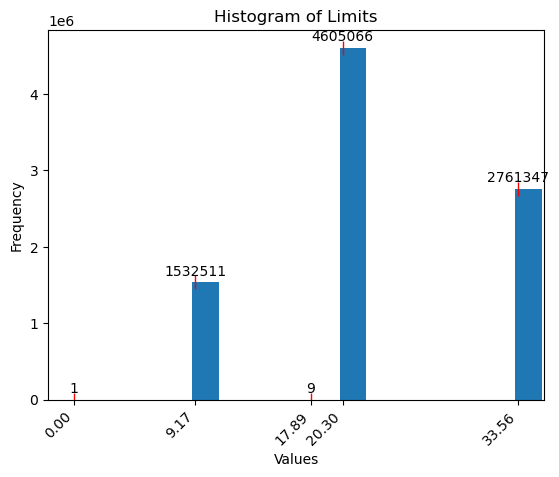

In [18]:
import matplotlib.pyplot as plt

sorted_unique = sorted(list(set(limits)))
min_diff = min([sorted_unique[i+1] - sorted_unique[i] for i in range(len(sorted_unique)-1)])
epsilon = min_diff * 0.1  # Adjust epsilon proportionally

bin_edges = [sorted_unique[0] - epsilon]
for i in range(1, len(sorted_unique)):
    bin_edges.append(sorted_unique[i] - epsilon)
bin_edges.append(sorted_unique[-1] + epsilon)

fig, ax = plt.subplots()
n, bins, _ = ax.hist(limits, bins=bin_edges, width=2)

for i in range(len(sorted_unique)):
    ax.plot(sorted_unique[i], n[i], 'k|', markersize=10, markeredgecolor='red', markerfacecolor='red') # Plot a vertical line with a marker
    ax.annotate(f'{int(n[i])}', xy=(sorted_unique[i], n[i]), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

ax.set_xlabel('Values / ')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Limits')
ax.set_xticks(sorted_unique)

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')

plt.show()

The problem seems to be caused by the single error caused by the lower limit of `0.1000E-10`.
```
42042175  445:  2025/01/31  13:07:17  Limit   =  0.1000E-10
42042176  445:  2025/01/31  13:07:17  p (hPa) =    132.9340
42042177  445:  2025/01/31  13:07:17  Value   =  0.1271E-13
42042178  445:  2025/01/31  13:07:17  fatal error in module rttov_check_profiles.F90:0399
```

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Survivorship-bias.svg/450px-Survivorship-bias.svg.png)

## Get the run back on track

The idea here is that we modify the parameter space by a unnoticable amount. Unnoticable for the overall model behaviour, but enough to get the determenistic ICON run on a slightly different trajectory. Hauke suggested manipulating the diffusion, Lukas suggested manipulating the `rayleigh_coeff` by a $10^{-3}$. So I tried the latter:

```diff
- rayleigh_coeff   =  0.25   ! default (0.05; higher values are recommended for R2B6 and finer)
+ rayleigh_coeff   =  0.251  ! default (0.05; higher values are recommended for R2B6 and finer)
```

If this does not work, I could try a more severe disturbation (e.g. $20\%$). This would have to be changed back at the next restart interval. A small change like $10^{-3}$ can be left in place as it is roughly the same number.

In [2]:
import os
import shutil

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
link = os.path.join(path, 'multifile_restart_atm.mfr')
restart_date = extract_datetime(os.readlink(link))
print('restart date:', restart_date)

files = [f for f in os.listdir(path) if has_timestamp(f)]         # everything with a timestamp
files = [f for f in files if not f == os.readlink(link)]          # but not the currently used restart file
files = [f for f in files if extract_datetime(f) >= restart_date] # files for after the restart
files = [os.path.join(path, f) for f in files]                    # convert to full paths
files = sorted(files, key=extract_datetime)                       # sort

destination = os.path.join(path, pd.Timestamp.now().strftime('%Y%m%dT%HZ'))


if len(files): 
    os.makedirs(destination, exist_ok=True)
    print(f'moving files to destination: `{os.path.basename(destination)}`')
    for file in files:
        print(file)
        shutil.move(file, destination)
else:
    print('no files to move.')

restart date: 2020-01-25 13:30:00
moving files to destination: `20250213T16Z`
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/moist_adiabatic_05_DOM01_rttov_satsim_20200125T133000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/moist_adiabatic_05_DOM01_surface_20200125T133000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/moist_adiabatic_05_DOM01_radiation_20200125T133000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/moist_adiabatic_05_DOM01_surface_20200125T140000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/moist_adiabatic_05_DOM01_3D_20200125T140000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/moist_adiabatic_05_DOM01_rttov_satsim_20200125T140000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/moist_adiabatic_05_DOM01_plevel_20200125T140000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/

Another try with a slightly stronger manipulation
```diff
- rayleigh_coeff   =  0.25   ! default (0.05; higher values are recommended for R2B6 and finer)
+ rayleigh_coeff   =  0.26   ! default (0.05; higher values are recommended for R2B6 and finer)
```